In [2]:
import pandas as pd
import numpy as np 
np.set_printoptions(suppress=True)

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from diffprivlib.models import StandardScaler as DPStandardScaler
from sklearn import preprocessing

In [6]:
covid_df = pd.read_csv('COVID-19_Case_Surveillance_Public_Use_Data_with_Geography.csv')[['case_month', 'res_state', 'age_group', 'sex', 'race', 'current_status', 'symptom_status', 'county_fips_code']]

C:\Users\dhh3hb\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
# covid_subdf = covid_df.sample(1000000)
# covid_subdf = covid_df.sample(10000000)
covid_subdf = covid_df


covid_subdf.to_csv('COVID/covid_trim.csv', index = False)

In [8]:
covid_subdf['county_fips_code']

17536841    51059.0
6701568     12103.0
16564604    27053.0
22060485    31043.0
20820700    37119.0
             ...   
2650286     40031.0
4980287     25023.0
15656869     6025.0
14263535     6075.0
10571206    17031.0
Name: county_fips_code, Length: 1000000, dtype: float64

In [ ]:
covid_df.res_state.unique()

In [28]:
insurance_df = pd.read_csv('ASEC_CENSUS/raw/pppub20.csv')
hh_df = pd.read_csv('ASEC_CENSUS/raw/hhpub20.csv')
f_df = pd.read_csv('ASEC_CENSUS/raw/ffpub20.csv')


In [29]:
supplement_df = hh_df[['H_SEQ', 'GEREG', 'GESTFIPS']].merge(f_df[['FH_SEQ', 'FOWNU18', 'FHIP_VAL']], left_on = 'H_SEQ', right_on = 'FH_SEQ' ).drop(['FH_SEQ'], axis = 1)
supplement_df

,H_SEQ,GEREG,GESTFIPS,FOWNU18,FHIP_VAL
0,1,1,23,0,5800
1,2,1,23,0,1500
2,3,1,23,0,1200
3,4,1,23,0,0
4,5,1,23,0,2500
...,...,...,...,...,...
69954,91497,4,15,0,0
69955,91498,4,15,0,1600
69956,91498,4,15,0,684
69957,91499,4,15,0,0


In [30]:
supplement_df['GESTFIPS'].unique()

array([23, 33, 50, 25, 44,  9, 36, 34, 42, 39, 18, 17, 26, 55, 27, 19, 29,
       38, 46, 31, 20, 10, 24, 11, 51, 54, 37, 45, 13, 12, 21, 47,  1, 28,
        5, 22, 40, 48, 30, 16, 56,  8, 35,  4, 49, 32, 53, 41,  6,  2, 15],
      dtype=int64)

In [31]:
insurance_df = insurance_df.merge(supplement_df, left_on = 'PH_SEQ', right_on = 'H_SEQ' ).drop(['H_SEQ'], axis = 1)
insurance_df.head()

,PERIDNUM,PH_SEQ,P_SEQ,A_LINENO,PF_SEQ,PHF_SEQ,OED_TYP1,OED_TYP2,OED_TYP3,PERRP,...,FILEDATE,FILESTAT,LJCW,NOEMP,WECLW,YYYYMM,GEREG,GESTFIPS,FOWNU18,FHIP_VAL
0,8329611509015080901101,1,1,1,1,1,0,0,0,40,...,31821,2,3,6,6,202003,1,23,0,5800
1,8329611509015080901102,1,2,2,1,1,0,0,0,42,...,31821,2,4,2,6,202003,1,23,0,5800
2,4238996011902050901101,2,1,1,1,1,0,0,0,40,...,31821,2,4,3,6,202003,1,23,0,1500
3,4238996011902050901102,2,2,2,1,1,0,0,0,42,...,31821,2,0,0,9,202003,1,23,0,1500
4,2059506120093750901101,3,1,1,1,1,0,0,0,41,...,31821,5,1,5,5,202003,1,23,0,1200


In [32]:
statecode_map = {
0 :"niu",
1 :"alabama",
2 :"alaska",
4 :"arizona",
5 :"arkansas",
6 :"california",
8 :"colorado",
9 :"connecticut",
10 :"delaware",
11 :"district of columbia",
12 :"florida",
13 :"georgia",
15 :"hawaii",
16 :"idaho",
17 :"illinois",
18 :"indiana",
19 :"iowa",
20 :"kansas",
21 :"kentucky",
22 :"louisiana",
23 :"maine",
24 :"maryland",
25 :"massachusetts",
26 :"michigan",
27 :"minnesota",
28 :"mississippi",
29 :"missouri",
30 :"montana",
31 :"nebraska",
32 :"nevada",
33 :"new hampshire",
34 :"new jersey",   
35 :"new mexico",
36 :"new york",
37 :"north carolina",
38 :"north dakota",
39 :"ohio",
40 :"oklahoma",
41 :"oregon",
42 :"pennsylvania",
44 :"rhode island",
45 :"south carolina",
46 :"south dakota",
47 :"tennessee",
48 :"texas",
49 :"utah",
50 :"vermont",
51 :"virginia",
53 :"washington",
54 :"west virginia",
55 :"wisconsin",
56 :"wyoming",
96 :"abroad",
}

state_initial_map = {
"Alabama": "AL",
"Alaska": "AK",
"American Samoa": "AS",
"Arizona": "AZ",
"Arkansas": "AR",
"California": "CA",
"Colorado": "CO",
"Connecticut": "CT",
"Delaware": "DE",
"District Of Columbia": "DC",
"Federated States Of Micronesia": "FM",
"Florida": "FL",
"Georgia": "GA",
"Guam": "GU",
"Hawaii": "HI",
"Idaho": "ID",
"Illinois": "IL",
"Indiana": "IN",
"Iowa": "IA",
"Kansas": "KS",
"Kentucky": "KY",
"Louisiana": "LA",
"Maine": "ME",
"Marshall Islands": "MH",
"Maryland": "MD",
"Massachusetts": "MA",
"Michigan": "MI",
"Minnesota": "MN",
"Mississippi": "MS",
"Missouri": "MO",
"Montana": "MT",
"Nebraska": "NE",
"Nevada": "NV",
"New Hampshire": "NH",
"New Jersey": "NJ",
"New Mexico": "NM",
"New York": "NY",
"North Carolina": "NC",
"North Dakota": "ND",
"Northern Mariana Islands": "MP",
"Ohio": "OH",
"Oklahoma": "OK",
"Oregon": "OR",
"Palau": "PW",
"Pennsylvania": "PA",
"Puerto Rico": "PR",
"Rhode Island": "RI",
"South Carolina": "SC",
"South Dakota": "SD",
"Tennessee": "TN",
"Texas": "TX",
"Utah": "UT",
"Vermont": "VT",
"Virgin Islands": "VI",
"Virginia": "VA",
"Washington": "WA",
"West Virginia": "WV",
"Wisconsin": "WI",
"Wyoming": "WY"
}
employment_map = {
    0 : 'N/A',
    1 : 'Working',
    2 : 'With job, not at work',
    3 : 'Unemployed, looking for work',
    4 : 'Unemployed, on layoff',
    7 : 'N/A',
}
education_map = {
    0 :"Children",
    31 :"High school or less",
    32 :"High school or less",
    33 :"High school or less",
    34 :"High school or less",
    35 :"High school or less",
    36 :"High school or less",
    37 :"High school or less",
    38 :"High school or less",
    39 :"High school or less",
    40 :"Some college but no degree",
    41 :"Associate degree",
    42 :"Associate degree",
    43 :"Bachelor's degree",
    44 :"Master's degree",
    45 :"Professional degree",
    46 :"Doctorate degree",
}
poverty_map = {
    0: 'N/A',
    1: 'Below Poverty Level',
    2: '100-124 % above poverty level',
    3: '125-149 % above poverty level',
    4: '150 and above poverty level'
}
income_map = {
    0 :'NO INCOME',
1 :'UNDER $2,500 OR LOSS',
2 :'$2,500 TO $4,999',
3 :'$5,000 TO $7,499',
4 :'$7,500 TO $9,999',
5 :'$10,000 TO $12,499',
6 :'$12,500 TO $14,999',
7 :'$15,000 TO $17,499',
8 :'$17,500 TO $19,999',
9 :'$20,000 TO $22,499',
10 :'$22,500 to $24,999',
11 :'$25,000 to $27,499',
12 :'$27,500 to $29,999',
13 :'$30,000 to $32,499',
14 :'$32,500 to $34,999',
15 :'$35,000 to $37,499',
16 :'$37,500 to $39,999',
17 :'$40,000 to $42,499',
18 :'$42,500 to $44,999',
19 :'$45,000 to $47,499',
20 :'$47,500 to $49,999',
21 :'$50,000 to $52,499',
22 :'$52,500 to $54,999',
23 :'$55,000 to $57,499',
24 :'$57,500 to $59,999',
25 :'$60,000 to $62,499',
26 :'$62,500 to $64,999',
27 :'$65,000 to $67,499',
28 :'$67,500 to $69,999',
29 :'$70,000 to $72,499',
30 :'$72,500 to $74,999',
31 :'$75,000 to $77,499',
32 :'$77,500 to $79,999',
33 :'$80,000 to $82,499',
34 :'$82,500 to $84,999',
35 :'$85,000 to $87,499',
36 :'$87,500 to $89,999',
37 :'$90,000 to $92,499',
38 :'$92,500 to $94,999',
39 :'$95,000 to $97,499',
40 :'$97,500 to $99,999',
41 :'$100,000 and over',

}

income_map = {
    0 :'NO INCOME',
1 :'$9,999 or less',
2 :'$9,999 or less',
3 :'$9,999 or less',
4 :'$9,999 or less',
5 :'$10,000 to $29,999',
6 :'$10,000 to $29,999',
7 :'$10,000 to $29,999',
8 :'$10,000 to $29,999',
9 :'$10,000 to $29,999',
10 :'$10,000 to $29,999',
11 :'$10,000 to $29,999',
12 :'$10,000 to $29,999',
13 :'$30,000 to $59,999',
14 :'$30,000 to $59,999',
15 :'$30,000 to $59,999',
16 :'$30,000 to $59,999',
17 :'$30,000 to $59,999',
18 :'$30,000 to $59,999',
19 :'$30,000 to $59,999',
20 :'$30,000 to $59,999',
21 :'$30,000 to $59,999',
22 :'$30,000 to $59,999',
23 :'$30,000 to $59,999',
24 :'$30,000 to $59,999',
25 :'$60,000 to $99,999',
26 :'$60,000 to $99,999',
27 :'$60,000 to $99,999',
28 :'$60,000 to $99,999',
29 :'$60,000 to $99,999',
30 :'$60,000 to $99,999',
31 :'$60,000 to $99,999',
32 :'$60,000 to $99,999',
33 :'$60,000 to $99,999',
34 :'$60,000 to $99,999',
35 :'$60,000 to $99,999',
36 :'$60,000 to $99,999',
37 :'$60,000 to $99,999',
38 :'$60,000 to $99,999',
39 :'$60,000 to $99,999',
40 :'$60,000 to $99,999',
41 :'$100,000 and over',

}

In [33]:
set(income_map.values())

{'$10,000 to $29,999',
 '$100,000 and over',
 '$30,000 to $59,999',
 '$60,000 to $99,999',
 '$9,999 or less',
 'NO INCOME'}

In [34]:
TARGET_VARIABLES = {
    'PRDTRACE': 'Race' ,
    'PERLIS': 'Poverty Level' ,
    'A_AGE': 'Age',
    'A_HGA': 'Educational Attainment',
    'A_LFSR': 'Employment Status',
    'A_SEX': 'Gender',
    'FOWNU18': 'Number of Children',
    'GEREG': 'Geographic Region',
    'GESTFIPS': 'State Code',
    'DIS_HP': 'Health Problems',


    'HIPAID': 'Employer Paid', #NIU, All, Part, None
    'NOW_HIPAID': 'Employer Currently Paid',
    'PTOT_R': 'Total Income (code)',
    'PTOTVAL': 'Total Income (val)',
    'COV': 'Coverage Last Year', #0: infant, #1: Yes, #2: No
    'NOW_COV': 'Coverage Now',
    'NOW_PRIV' : 'Private Coverage Now', 
    'PRIV': 'Private Coverage Last Year',
    'NOW_PUB': 'Public Coverage Now',
    'PUB': 'Public Coverage Last Year',
    'DIR': 'Direct-purchase Coverage Last Year',
    'NOW_DIR': 'Direct-purchase Coverage Now',
    'MRK': 'Marketplace Coverage Last Year',
    'NOW_MRK': 'Marketplace Coverage Now',
    'NONM': 'Non-Marketplace Coverage Last Year',
    'NOW_NONM': 'Non-Marketplace Coverage Now',

    'MCARE': 'Medicare Coverage Last Year',
    'NOW_MCARE': 'Medicare Coverage Now',
    'MIL': "TRICARE Coverage Last Year",
    'NOW_MIL': "TRICARE Coverage Now",
    'VACARE': 'VACARE Coverage Last Year',
    'NOW_VACARE': 'VACARE Coverage Now',
    'MCAID': 'Medicaid Coverage Last Year',
    'NOW_MCAID': 'Medicaid Coverage Now',
    'MOOP2': 'Total Out-of-Pocket Expenditures',
    'PEMCPREM': 'Medicare premium amount',
    'PHIP_VAL': 'Total Premium Paid'
}

0         ME
1         ME
2         ME
3         ME
4         ME
          ..
193721    HI
193722    HI
193723    HI
193724    HI
193725    HI
Name: State Code, Length: 193726, dtype: object

In [35]:
insurance_df_subset = insurance_df[TARGET_VARIABLES.keys()]

temp = insurance_df.copy()
insurance_df_subset.columns = TARGET_VARIABLES.values()
insurance_df_subset['State Code'] = insurance_df_subset['State Code'].astype(int).map(statecode_map).str.title().map(state_initial_map) #convert to initial
insurance_df_subset['Employment Status'] = insurance_df_subset['Employment Status'].astype(int).map(employment_map) #convert to employment
insurance_df_subset['Educational Attainment'] = insurance_df_subset['Educational Attainment'].astype(int).map(education_map) #convert to education
insurance_df_subset['Poverty Level'] = insurance_df_subset['Poverty Level'].astype(int).map(poverty_map) #convert to education

insurance_df_subset['Total Income (code)'] = insurance_df_subset['Total Income (code)'].astype(int).map(income_map) #convert to education


insurance_df_subset.to_csv('ASEC_Census/2021.csv', index = False)

insurance_df_subset = temp
insurance_df_subset.head()

<ipython-input-35-0ce2e66f2f45>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_df_subset['State Code'] = insurance_df_subset['State Code'].astype(int).map(statecode_map).str.title().map(state_initial_map) #convert to initial
<ipython-input-35-0ce2e66f2f45>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_df_subset['Employment Status'] = insurance_df_subset['Employment Status'].astype(int).map(employment_map) #convert to employment
<ipython-input-35-0ce2e66f2f45>:7: SettingWithCopyWarni

,PERIDNUM,PH_SEQ,P_SEQ,A_LINENO,PF_SEQ,PHF_SEQ,OED_TYP1,OED_TYP2,OED_TYP3,PERRP,...,FILEDATE,FILESTAT,LJCW,NOEMP,WECLW,YYYYMM,GEREG,GESTFIPS,FOWNU18,FHIP_VAL
0,8329611509015080901101,1,1,1,1,1,0,0,0,40,...,31821,2,3,6,6,202003,1,23,0,5800
1,8329611509015080901102,1,2,2,1,1,0,0,0,42,...,31821,2,4,2,6,202003,1,23,0,5800
2,4238996011902050901101,2,1,1,1,1,0,0,0,40,...,31821,2,4,3,6,202003,1,23,0,1500
3,4238996011902050901102,2,2,2,1,1,0,0,0,42,...,31821,2,0,0,9,202003,1,23,0,1500
4,2059506120093750901101,3,1,1,1,1,0,0,0,41,...,31821,5,1,5,5,202003,1,23,0,1200


In [25]:
insurance_df_subset.head()

,Race,Poverty Level,Age,Educational Attainment,Employment Status,Gender,Number of Children,Geographic Region,State Code,Health Problems,...,Medicare Coverage Now,TRICARE Coverage Last Year,TRICARE Coverage Now,VACARE Coverage Last Year,VACARE Coverage Now,Medicaid Coverage Last Year,Medicaid Coverage Now,Total Out-of-Pocket Expenditures,Medicare premium amount,Total Premium Paid
0,1,150 and above poverty level,63,High school or less,Working,2,0,1,ME,2,...,2,2,2,2,2,2,2,7550,0,5800
1,1,150 and above poverty level,67,High school or less,N/A,1,0,1,ME,2,...,1,2,2,2,2,2,2,1750,1626,0
2,1,150 and above poverty level,64,High school or less,Working,1,0,1,ME,2,...,2,1,1,2,2,2,2,1500,0,1500
3,1,150 and above poverty level,71,High school or less,N/A,2,0,1,ME,2,...,1,1,1,2,2,2,2,100,1680,0
4,1,150 and above poverty level,54,High school or less,Working,2,0,1,ME,2,...,2,2,2,2,2,2,2,2300,0,1200


<H1> Scenario 1 

In [127]:
# Age, Employment, Area, Income, Dependents, Premium

In [49]:
TARGET_VARIABLES_1 = {
    'A_AGE': 'Age',
    'A_LFSR': 'Employment Status',
    'FOWNU18': 'Number of Children',
    'GEREG': 'Geographic Region',
    'PTOT_R': 'Total Income (code)',
    'DIS_HP': 'Health Problems',

    # 'HIPAID': 'Employer Paid',
    # 'NOW_HIPAID': 'Employer Currently Paid',
    'NOW_COV': 'Coverage Now',
    # 'COV': 'Coverage Last Year', #0: infant, #1: Yes, #2: No
    # 'NOW_PUB': 'Public Coverage Now',
    # 'PUB': 'Public Coverage Last Year',
    # 'PRIV': 'Private Coverage Last Year',
    # 'MOOP2': 'Total Out-of-Pocket Expenditures',
    'PHIP_VAL': 'Total Premium Paid',

}

In [22]:
insurance_df_subset.head()

,Race,Poverty Level,Age,Educational Attainment,Employment Status,Gender,Number of Children,Geographic Region,State Code,Health Problems,...,Medicare Coverage Now,TRICARE Coverage Last Year,TRICARE Coverage Now,VACARE Coverage Last Year,VACARE Coverage Now,Medicaid Coverage Last Year,Medicaid Coverage Now,Total Out-of-Pocket Expenditures,Medicare premium amount,Total Premium Paid
0,1,150 and above poverty level,63,High school or less,Working,2,0,1,ME,2,...,2,2,2,2,2,2,2,7550,0,5800
1,1,150 and above poverty level,67,High school or less,N/A,1,0,1,ME,2,...,1,2,2,2,2,2,2,1750,1626,0
2,1,150 and above poverty level,64,High school or less,Working,1,0,1,ME,2,...,2,1,1,2,2,2,2,1500,0,1500
3,1,150 and above poverty level,71,High school or less,N/A,2,0,1,ME,2,...,1,1,1,2,2,2,2,100,1680,0
4,1,150 and above poverty level,54,High school or less,Working,2,0,1,ME,2,...,2,2,2,2,2,2,2,2300,0,1200


In [45]:
DF_TARGET_1['PHIP_VAL'].mean()/12

231.0381906825569

In [48]:
DF_TARGET_1 = insurance_df_subset[TARGET_VARIABLES_1.keys()].sample(3000, replace = False)
DF_TARGET_1 = DF_TARGET_1[DF_TARGET_1['NOW_COV'] == 1].drop(['NOW_COV'], axis = 1) #insured and paid only
DF_TARGET_1 = DF_TARGET_1[DF_TARGET_1['PHIP_VAL'] > 0] #amount > 0
DF_TARGET_1 = DF_TARGET_1[DF_TARGET_1['A_AGE'] >= 18]#adult only

DF_TARGET_1.head()

,A_AGE,A_LFSR,GEREG,PTOT_R,DIS_HP,PHIP_VAL
35220,42,7,2,1,1,4420
122395,49,1,3,41,2,5000
61640,23,1,2,12,2,250
45922,62,7,2,11,2,6800
117724,43,3,3,1,2,400


In [383]:
DF_TARGET_1[(DF_TARGET_1['DIS_HP'] == 1) & (DF_TARGET_1['PRIV'] == 1) & (DF_TARGET_1['NOW_PUB'] == 2)]

,A_AGE,A_LFSR,FOWNU18,GEREG,PTOT_R,DIS_HP,HIPAID,NOW_HIPAID,COV,NOW_PUB,PUB,PRIV,PHIP_VAL
138917,38,1,2,4,28,1,2,2,1,2,2,1,4000
142026,59,7,0,4,19,1,2,2,1,2,2,1,1400
59497,64,7,0,2,1,1,0,0,1,2,2,1,948
78927,53,7,1,3,38,1,2,2,1,2,2,1,6480
2254,50,7,0,1,9,1,2,2,1,2,2,1,1300
134026,42,1,2,3,33,1,2,2,1,2,2,1,676
65357,65,1,0,2,22,1,2,2,1,2,2,1,1400
179421,64,1,0,4,41,1,2,2,1,2,2,1,1000
138551,25,1,0,4,24,1,2,0,1,2,2,1,3000
178211,24,7,0,4,15,1,2,2,1,2,2,1,1200


In [407]:
DF_TARGET_1[DF_TARGET_1['PHIP_VAL'] == 0][['NOW_PUB','PUB','PRIV', 'PHIP_VAL']].groupby(['NOW_PUB', 'PUB', 'PRIV', 'PHIP_VAL']).size()


NOW_PUB  PUB  PRIV  PHIP_VAL
1        1    1     0            84
              2     0           420
         2    1     0             1
              2     0             4
2        1    2     0             3
         2    1     0           518
              2     0             8
dtype: int64

In [384]:
DF_TARGET_1.corr()

,A_AGE,A_LFSR,FOWNU18,GEREG,PTOT_R,DIS_HP,HIPAID,NOW_HIPAID,COV,NOW_PUB,PUB,PRIV,PHIP_VAL
A_AGE,1.000000,0.517965,-0.296751,-0.009336,-0.079414,-0.140081,-0.340716,-0.349057,-0.004811,-0.630592,-0.622442,0.285379,-0.061562
A_LFSR,0.517965,1.000000,-0.192353,-0.003993,-0.444629,-0.288480,-0.464296,-0.463069,-0.020465,-0.616052,-0.607784,0.310511,-0.104355
FOWNU18,-0.296751,-0.192353,1.000000,-0.008655,0.151775,0.067116,0.090117,0.093560,-0.018977,0.240828,0.230779,-0.122974,0.140974
GEREG,-0.009336,-0.003993,-0.008655,1.000000,-0.011875,0.013577,-0.061854,-0.072877,0.039339,0.004946,-0.003157,0.005621,-0.052908
PTOT_R,-0.079414,-0.444629,0.151775,-0.011875,1.000000,0.111490,0.295460,0.280761,-0.050665,0.276252,0.280029,-0.216377,0.222399
DIS_HP,-0.140081,-0.288480,0.067116,0.013577,0.111490,1.000000,0.131522,0.133759,0.007840,0.201608,0.199926,-0.125387,0.074406
HIPAID,-0.340716,-0.464296,0.090117,-0.061854,0.295460,0.131522,1.000000,0.963293,-0.045293,0.510245,0.505962,-0.451222,0.185401
NOW_HIPAID,-0.349057,-0.463069,0.093560,-0.072877,0.280761,0.133759,0.963293,1.000000,-0.044192,0.518521,0.509335,-0.433073,0.177842
COV,-0.004811,-0.020465,-0.018977,0.039339,-0.050665,0.007840,-0.045293,-0.044192,1.000000,0.019100,0.019204,0.100377,-0.020460
NOW_PUB,-0.630592,-0.616052,0.240828,0.004946,0.276252,0.201608,0.510245,0.518521,0.019100,1.000000,0.989125,-0.537999,0.152603


In [386]:
X = DF_TARGET_1.loc[:, 'A_AGE': 'PRIV']
y = DF_TARGET_1[['PHIP_VAL']]/1000
display(X.head())
display(y.head())

,A_AGE,A_LFSR,FOWNU18,GEREG,PTOT_R,DIS_HP,HIPAID,NOW_HIPAID,COV,NOW_PUB,PUB,PRIV
75191,26,1,2,3,15,2,2,2,1,2,2,1
23129,40,1,1,1,41,2,2,2,1,2,2,1
85967,47,1,2,3,28,2,0,0,1,2,2,1
138321,47,1,3,4,41,2,2,2,1,2,2,1
102885,50,1,0,3,20,2,2,2,1,2,2,1


,PHIP_VAL
75191,0.96
23129,9.70
85967,0.05
138321,8.00
102885,4.16


In [387]:
y.describe()

,PHIP_VAL
count,956.000000
mean,2.742895
std,2.916254
min,0.001000
25%,0.789000
50%,1.920000
75%,3.600000
max,23.000000


In [388]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
# Split train" into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=96)

In [389]:
y_test

,PHIP_VAL
127128,0.130
112590,0.500
31861,2.400
62200,2.800
105350,1.900
...,...
64540,0.060
91378,2.000
46424,1.875
160471,0.216


In [390]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)
# Z_test = scaler_X.transform(Z)
scaler_y = MinMaxScaler()
# scaler_y = RobustScaler()
# y_train = scaler_y.fit_transform(y_train)
# y_val = scaler_y.transform(y_val)
# y_test = scaler_y.transform(y_test)

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [391]:
X_train

array([[ 0.71739897, -0.63101802, -0.60269374, ...,  0.59360105,
         0.59584359, -0.34744465],
       [-1.25568753, -0.63101802,  0.44025488, ...,  0.59360105,
         0.59584359, -0.34744465],
       [ 0.11949397, -0.63101802, -0.60269374, ...,  0.59360105,
         0.59584359, -0.34744465],
       ...,
       [-0.95673503, -0.63101802,  1.48320349, ...,  0.59360105,
         0.59584359, -0.34744465],
       [-0.41862053, -0.63101802,  1.48320349, ...,  0.59360105,
         0.59584359, -0.34744465],
       [-1.37526853, -0.63101802, -0.60269374, ...,  0.59360105,
         0.59584359, -0.34744465]])

In [392]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
# unseen_dataset = RegressionDataset(torch.from_numpy(Z_test).float(), torch.from_numpy(y_test).float())

In [393]:
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
# unseen_loader = DataLoader(dataset=unseen_dataset, batch_size=1)

In [394]:
X.shape

(956, 12)

In [395]:
# 

class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        self.layer_1 = nn.Linear(num_features, 32)
        self.layer_2 = nn.Linear(32, 64)
        self.layer_3 = nn.Linear(64, 128)
        self.layer_4 = nn.Linear(128, 256)
        self.layer_5 = nn.Linear(256, 256)
        self.layer_6 = nn.Linear(256, 128)
        self.layer_7 = nn.Linear(128, 64)
        self.layer_8 = nn.Linear(64, 32)
        self.layer_9 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.relu2 = nn.LeakyReLU()

    def forward(self, inputs):
      x = self.relu(self.layer_1(inputs))
      x = self.relu2(self.layer_2(x))
      x = self.relu(self.layer_3(x))
      x = self.relu2(self.layer_4(x))
      x = self.relu(self.layer_5(x))
      x = self.relu2(self.layer_6(x))
      x = self.relu(self.layer_7(x))
      x = self.relu2(self.layer_8(x))
      x = self.relu(self.layer_9(x))
      x = self.layer_out(x)
      return (x)
    def predict(self, test_inputs):
      x = self.relu(self.layer_1(test_inputs))
      x = self.relu2(self.layer_2(x))
      x = self.relu(self.layer_3(x))
      x = self.relu2(self.layer_4(x))
      x = self.relu(self.layer_5(x))
      x = self.relu2(self.layer_6(x))
      x = self.relu(self.layer_7(x))
      x = self.relu2(self.layer_8(x))
      x = self.relu(self.layer_9(x))
      x = self.layer_out(x)
      return (x)

# class MultipleRegression(nn.Module):
#     def __init__(self, num_features):
#         super(MultipleRegression, self).__init__()
        
#         self.layer_1 = nn.Linear(num_features, 16)
#         self.layer_2 = nn.Linear(16, 32)
#         self.layer_3 = nn.Linear(32, 16)
#         self.layer_out = nn.Linear(16, 1)
        
#         self.relu = nn.ReLU()
#     def forward(self, inputs):
#             x = self.relu(self.layer_1(inputs))
#             x = self.relu(self.layer_2(x))
#             x = self.relu(self.layer_3(x))
#             x = self.layer_out(x)
#             return (x)
#     def predict(self, test_inputs):
#             x = self.relu(self.layer_1(test_inputs))
#             x = self.relu(self.layer_2(x))
#             x = self.relu(self.layer_3(x))
#             x = self.layer_out(x)
#             return (x)

In [396]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


cuda:0
MultipleRegression(
  (layer_1): Linear(in_features=12, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=256, bias=True)
  (layer_6): Linear(in_features=256, out_features=128, bias=True)
  (layer_7): Linear(in_features=128, out_features=64, bias=True)
  (layer_8): Linear(in_features=64, out_features=32, bias=True)
  (layer_9): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (relu2): LeakyReLU(negative_slope=0.01)
)


In [397]:
loss_stats = {
    'train': [],
    "val": []
}
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        # print(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
            
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 001: | Train Loss: 16.06159 | Val Loss: 16.17347
Epoch 002: | Train Loss: 15.06149 | Val Loss: 15.59010
Epoch 003: | Train Loss: 14.60600 | Val Loss: 13.07863
Epoch 004: | Train Loss: 10.53674 | Val Loss: 7.82694
Epoch 005: | Train Loss: 9.83958 | Val Loss: 7.71822
Epoch 006: | Train Loss: 9.57478 | Val Loss: 7.50801
Epoch 007: | Train Loss: 8.65530 | Val Loss: 7.51345
Epoch 008: | Train Loss: 8.59085 | Val Loss: 7.67346
Epoch 009: | Train Loss: 7.92647 | Val Loss: 7.67635
Epoch 010: | Train Loss: 8.25019 | Val Loss: 7.76637
Epoch 011: | Train Loss: 8.22469 | Val Loss: 7.78412
Epoch 012: | Train Loss: 8.61780 | Val Loss: 7.79221
Epoch 013: | Train Loss: 7.83709 | Val Loss: 7.79728
Epoch 014: | Train Loss: 7.50716 | Val Loss: 7.84161
Epoch 015: | Train Loss: 8.14628 | Val Loss: 7.80467
Epoch 016: | Train Loss: 8.72485 | Val Loss: 7.76250
Epoch 017: | Train Loss: 7.89134 | Val Loss: 7.75868
Epoch 018: | Train Loss: 7.54466 | Val Loss: 7.75580
Epoch 019: | Train Loss: 7.52866 | Val 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

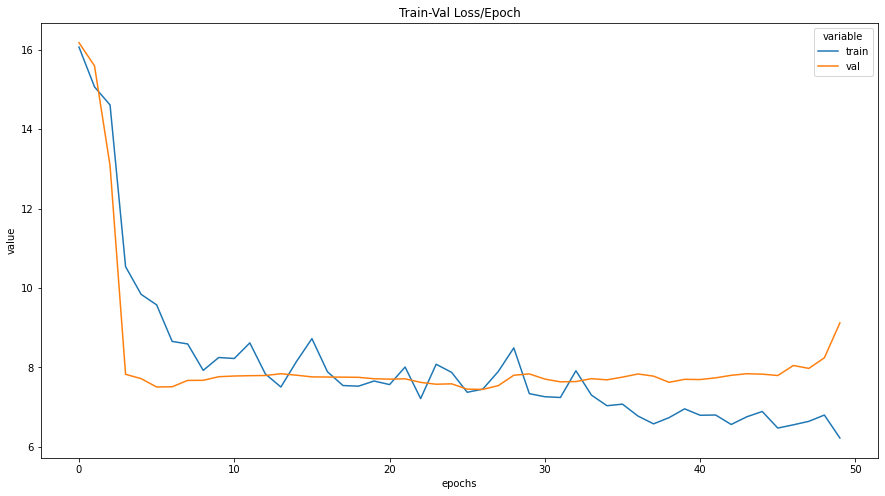

In [398]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [403]:
''''Testing'''
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_real = [a.squeeze().tolist() for a in y_test];
X_test_real = [a.squeeze().tolist() for a in X_test]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

# inverse_y_real = scaler_y.inverse_transform(np.array(y_real).reshape(-1,1)).reshape(-1,)
# inverse_y_pred = scaler_y.inverse_transform(np.array(y_pred_list).reshape(-1,1)).reshape(-1,)
# pd.DataFrame(data = [inverse_y_real, inverse_y_pred]).T
result_df = pd.DataFrame(data = [X_test_real,y_real, y_pred_list]).T
result_df.columns = ['X', 'Y_true', 'Y_predict']
result_df



,X,Y_true,Y_predict
0,"[-0.8371540312361629, 0.13220271967924602, 2.5...",0.13,7.15524
1,"[1.0163514686324886, -0.24940765183185507, -0....",0.5,0.536922
2,"[1.4946754685985921, 1.6586442057236506, -0.60...",2.4,2.48734
3,"[0.11949396869604427, -0.6310180233429561, 0.4...",2.8,3.12625
4,"[0.2390749686875702, -0.6310180233429561, -0.6...",1.9,4.24788
...,...,...,...
187,"[-1.7938020311683702, -0.6310180233429561, -0....",0.06,0.903066
188,"[2.0925804685562217, -0.6310180233429561, -0.6...",2,5.53838
189,"[0.6576084686579109, -0.6310180233429561, 1.48...",1.875,4.27281
190,"[0.17928446869180723, -0.6310180233429561, -0....",0.216,2.77168


<h1>Kaggle Dataset

In [50]:
DF_TARGET_Kag = pd.read_csv('kaggle-insurance.csv')
DF_TARGET_Kag.head() 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [53]:
DF_TARGET_Kag['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [455]:
map_sex = {
    'male': 0,
    'female': 1
}
map_smoker = {
    'no': 0,
    'yes': 1,
}
# le = preprocessing.LabelEncoder()
# le.fit_transform(DF_TARGET_Kag.region.values)
# map_region = dict(zip(le.classes_, range(len(le.classes_))))
map_region = {'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}

In [ ]:
le

In [456]:
X = DF_TARGET_Kag.loc[:, 'age': 'region']
X.region = pd.Categorical(X.region)
X['sex'] = X.sex.map(map_sex)
X['smoker'] = X.smoker.map(map_smoker)
X['region'] = X.region.map(map_region)

# X = DF_TARGET_Kag.loc[:, ['age','smoker', 'children']]
# X.smoker = pd.Categorical(X.smoker)
# X['smoker'] = X.smoker.cat.codes


y = DF_TARGET_Kag.charges/10000

display(X.head())
display(y.head())

,age,sex,bmi,children,smoker,region
0,19,1,27.900,0,1,3
1,18,0,33.770,1,0,2
2,28,0,33.000,3,0,2
3,33,0,22.705,0,0,1
4,32,0,28.880,0,0,1


0    1.688492
1    0.172555
2    0.444946
3    2.198447
4    0.386686
Name: charges, dtype: float64

In [461]:
X_train, y_train

(array([[49.  ,  1.  , 30.78,  1.  ,  0.  ,  0.  ],
        [23.  ,  0.  , 37.1 ,  3.  ,  0.  ,  3.  ],
        [18.  ,  0.  , 38.17,  0.  ,  1.  ,  2.  ],
        ...,
        [62.  ,  1.  , 29.92,  0.  ,  0.  ,  2.  ],
        [43.  ,  1.  , 32.56,  3.  ,  1.  ,  2.  ],
        [26.  ,  1.  , 29.64,  4.  ,  0.  ,  0.  ]]),
 365     0.977835
 817     0.359760
 759     3.630780
 1035    1.209448
 1323    4.389638
           ...   
 410     0.162134
 353     1.240488
 789     1.345796
 1152    4.094129
 321     2.467166
 Name: charges, Length: 963, dtype: float64)

In [490]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
# Split train" into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=96)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
# unseen_dataset = RegressionDataset(torch.from_numpy(Z_test).float(), torch.from_numpy(y_test).float())

EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_FEATURES = len(X.columns)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
# unseen_loader = DataLoader(dataset=unseen_dataset, batch_size=1)

In [491]:
NUM_FEATURES

6

In [492]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


cuda:0
MultipleRegression(
  (layer_1): Linear(in_features=6, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=256, bias=True)
  (layer_6): Linear(in_features=256, out_features=128, bias=True)
  (layer_7): Linear(in_features=128, out_features=64, bias=True)
  (layer_8): Linear(in_features=64, out_features=32, bias=True)
  (layer_9): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (relu2): LeakyReLU(negative_slope=0.01)
)


In [493]:
loss_stats = {
    'train': [],
    "val": []
}
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        # print(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
            
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


C:\Users\dhh3hb\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dhh3hb\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dhh3hb\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_los

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

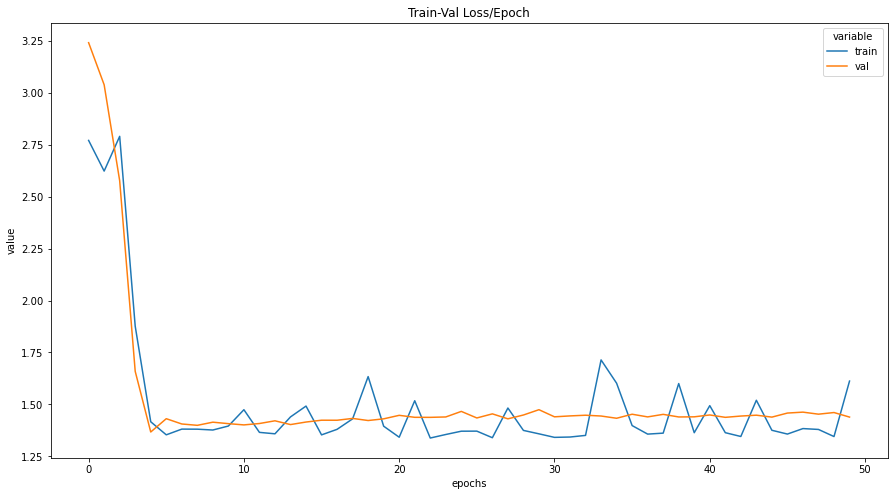

In [494]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [495]:
torch.save(model.state_dict(), 'model/model_quick.pth')

In [431]:
''''Testing'''
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_real = [a.squeeze().tolist() for a in y_test];
X_test_real = [a.squeeze().tolist() for a in X_test]
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

# inverse_y_real = scaler_y.inverse_transform(np.array(y_real).reshape(-1,1)).reshape(-1,)
# inverse_y_pred = scaler_y.inverse_transform(np.array(y_pred_list).reshape(-1,1)).reshape(-1,)
# pd.DataFrame(data = [inverse_y_real, inverse_y_pred]).T
pd.DataFrame(data = [X_test_real,y_real, y_pred_list]).T



,0,1,2
0,"[30.0, 1.0, 24.4, 3.0, 1.0, 3.0]",1.82592,1.03056
1,"[60.0, 1.0, 32.8, 0.0, 1.0, 3.0]",5.25908,1.42593
2,"[30.0, 0.0, 27.93, 0.0, 0.0, 0.0]",0.413752,1.05088
3,"[43.0, 0.0, 24.7, 2.0, 1.0, 1.0]",2.18808,1.06297
4,"[44.0, 0.0, 25.8, 1.0, 0.0, 3.0]",0.762463,1.07449
...,...,...,...
263,"[25.0, 1.0, 33.33, 2.0, 1.0, 2.0]",3.61246,1.30341
264,"[44.0, 0.0, 36.48, 0.0, 0.0, 0.0]",1.27972,1.35416
265,"[21.0, 0.0, 26.4, 1.0, 0.0, 3.0]",0.259778,1.01553
266,"[22.0, 1.0, 28.31, 1.0, 0.0, 1.0]",0.263904,1.10425
